In [3]:
!conda info --envs
!conda export -f env.yml

# conda environments:
#
base                     C:\Users\adith\miniconda3
activity                 C:\Users\adith\miniconda3\envs\activity
anu                      C:\Users\adith\miniconda3\envs\anu
datasc                   C:\Users\adith\miniconda3\envs\datasc
eapp                     C:\Users\adith\miniconda3\envs\eapp
lidar                    C:\Users\adith\miniconda3\envs\lidar
nlp                      C:\Users\adith\miniconda3\envs\nlp
qml                      C:\Users\adith\miniconda3\envs\qml
ram                      C:\Users\adith\miniconda3\envs\ram
tf                       C:\Users\adith\miniconda3\envs\tf
torch                 *  C:\Users\adith\miniconda3\envs\torch
women_safety             C:\Users\adith\miniconda3\envs\women_safety
                         c:\Users\adith\miniconda3
datasc                   c:\Users\adith\miniconda3\envs\datasc
eapp                     c:\Users\adith\miniconda3\envs\eapp
torch                    c:\Users\adith\miniconda3\envs\torch



### IMPORT LIBRARIES

In [5]:
import os
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import pickle


In [6]:
# SET DEVICE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda


### SET DATA

In [7]:
DATA_DIR = r'D:\NGA_open_dataset'

In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

### IMPORT PRE TRAINED ResNet50

In [9]:
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))  # remove final FC layer
model.to(device)
model.eval()

c:\Users\adith\miniconda3\envs\torch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\adith\miniconda3\envs\torch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


## PICK HIGHLY SIMILAR IMAGES

❌ Skipping corrupted file: 005e6b6c-3b7f-4b95-ab10-7a91dfd41504.jpg (image file is truncated (63 bytes not processed))
❌ Skipping corrupted file: 006b7036-2863-42da-95f0-c7e23e49b2bc.jpg (image file is truncated (38 bytes not processed))
❌ Skipping corrupted file: 00707ebb-bf79-43fe-a129-fc423859cb47.jpg (image file is truncated (63 bytes not processed))
❌ Skipping corrupted file: 00772a7e-ab21-4e41-9b8c-e7d65cdc0c71.jpg (image file is truncated (63 bytes not processed))
❌ Skipping corrupted file: 008350be-2c5c-4e1d-af93-af9168a478a9.jpg (image file is truncated (40 bytes not processed))
❌ Skipping corrupted file: 0089f963-5517-4ba2-b734-daa6a0f222a7.jpg (image file is truncated (63 bytes not processed))
❌ Skipping corrupted file: 00aae6a6-8d24-4f6b-be0e-dc36bb83f165.jpg (image file is truncated (40 bytes not processed))
❌ Skipping corrupted file: 010ac9b4-3c13-4313-9e66-d8de843ac015.jpg (image file is truncated (63 bytes not processed))
❌ Skipping corrupted file: 010df55f-5246-4269-88

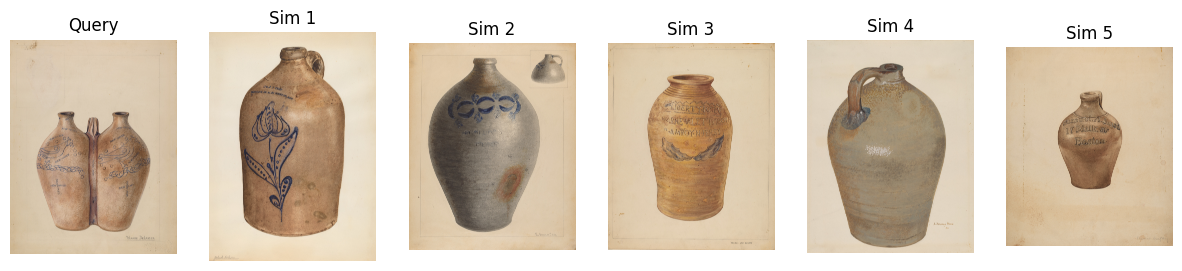

In [11]:

features_dict = {}
image_paths = []

def extract_features(img_path):
    image = Image.open(img_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        feat = model(image).squeeze().cpu().numpy()
    return feat

for img_name in os.listdir(DATA_DIR):
    if img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
        path = os.path.join(DATA_DIR, img_name)
        try:
            feat = extract_features(path)
            features_dict[img_name] = feat
            image_paths.append(path)
        except Exception as e:
            print(f"❌ Skipping corrupted file: {img_name} ({e})")

print(f"✅ Extracted features for {len(features_dict)} images.")

# Save features to disk
with open("features.pkl", "wb") as f:
    pickle.dump(features_dict, f)
print("📦 Saved features to features.pkl")

# Load features
with open("features.pkl", "rb") as f:
    features_dict = pickle.load(f)

# Build similarity matrix
all_feats = list(features_dict.values())
all_feats = np.array(all_feats)
similarity_matrix = cosine_similarity(all_feats)

# Function to plot similar images
def show_similar_images(query_index, top_k=5):
    query_img = image_paths[query_index]
    sim_scores = similarity_matrix[query_index]
    top_indices = sim_scores.argsort()[::-1][1:top_k+1]

    plt.figure(figsize=(15, 5))
    plt.subplot(1, top_k+1, 1)
    plt.imshow(Image.open(query_img))
    plt.title("Query")
    plt.axis('off')

    for i, idx in enumerate(top_indices):
        sim_img = image_paths[idx]
        plt.subplot(1, top_k+1, i+2)
        plt.imshow(Image.open(sim_img))
        plt.title(f"Sim {i+1}")
        plt.axis('off')
    plt.show()

# Try a few test queries
if len(image_paths) > 0:
    show_similar_images(query_index=0, top_k=5)
else:
    print("❗ No valid images to display.")

In [15]:
def find_similar_from_file(query_img_path, top_k=5):
    try:
        # Extract features from query image
        image = Image.open(query_img_path).convert("RGB")
        image = transform(image).unsqueeze(0).to(device)
        with torch.no_grad():
            query_feat = model(image).squeeze().cpu().numpy()

        # Compute cosine similarity with all existing features
        sim_scores = cosine_similarity([query_feat], all_feats)[0]
        top_indices = sim_scores.argsort()[::-1][:top_k]

        # Plot results
        plt.figure(figsize=(15, 5))
        plt.subplot(1, top_k+1, 1)
        plt.imshow(Image.open(query_img_path))
        plt.title("Query Image")
        plt.axis('off')

        for i, idx in enumerate(top_indices):
            sim_img_path = image_paths[idx]
            sim_name = os.path.basename(sim_img_path)[:20]  # Get filename, max 20 chars
            plt.subplot(1, top_k+1, i+2)
            plt.imshow(Image.open(sim_img_path))
            plt.title(f"{sim_name}", fontsize=8)
            plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"❌ Error processing query image: {e}")


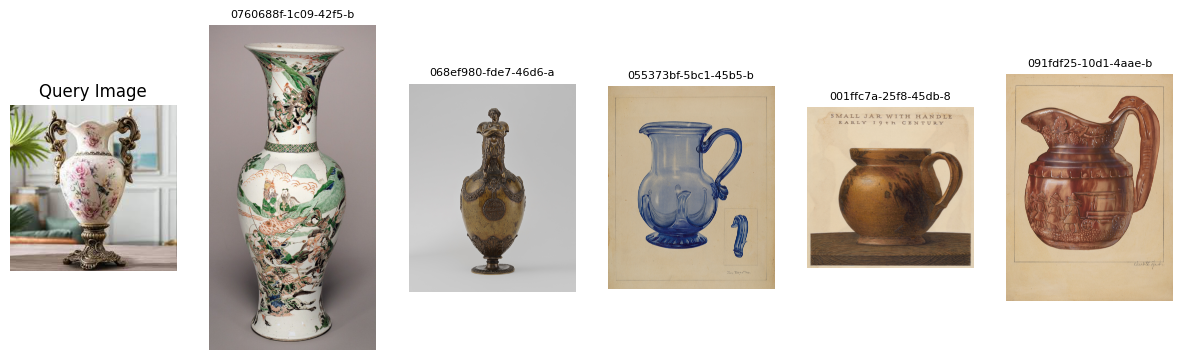

In [18]:
find_similar_from_file("vase.jpg", top_k=5)


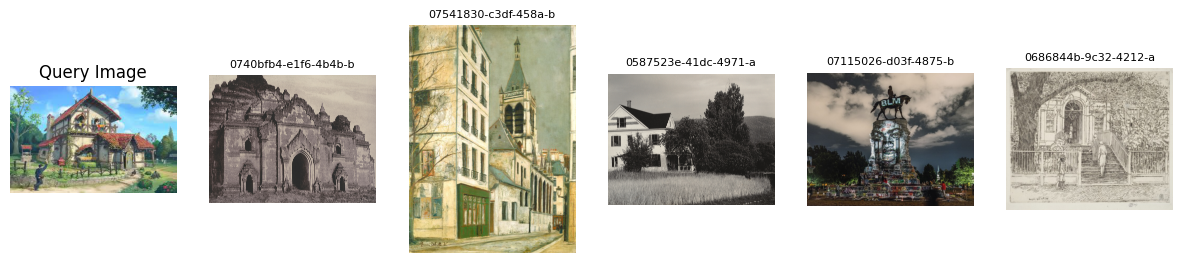

In [20]:
find_similar_from_file("house.jpg", top_k=5)